In [120]:
import warnings

warnings.filterwarnings('ignore')

In [121]:
import pandas as pd

In [ ]:
import seaborn

In [122]:
dfb = pd.read_csv('/Users/qasem/PycharmProjects/grad_ecc_RL_data/RL_behavior.csv')  # df behaviour

In [123]:
dfb.shape

(12170, 7)

In [124]:
dfb.head()

,Subject,Block,Trial,Score,ReactionTime,MovementTime,Valid
0,AB1,1,1,53.0,0.365009,0.182444,True
1,AB1,1,2,51.0,0.548555,0.402011,True
2,AB1,1,3,7.0,0.472627,0.269147,True
3,AB1,1,4,0.0,0.557651,0.289636,True
4,AB1,1,5,34.0,0.588884,0.211777,True


<AxesSubplot:xlabel='Block', ylabel='count'>

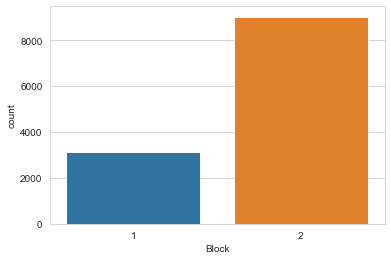

In [125]:
seaborn.countplot(data=dfb, x='Block')

In [126]:
# block 1 is baseline, 2 for learning (reward given)

In [127]:
dfb[dfb.Block==1].Trial.max()

70

In [128]:
dfb[dfb.Block==2].Trial.max()   # invalid. trial 200 is valid.

201

<AxesSubplot:xlabel='Trial', ylabel='Score'>

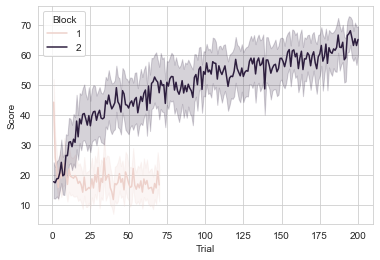

In [129]:
seaborn.lineplot(data=dfb, x='Trial', y='Score', hue='Block')

In [130]:
len_window = 30

In [131]:
df = dfb[dfb.Trial.isin(list(range(1,len_window+1)))].groupby(['Subject', 'Block']).Score.std()
df = df.rename('early_variability').reorder_levels([1,0])

In [132]:
df.head()

Block  Subject
1      AB1        17.603846
2      AB1        13.456588
1      AG1        13.700307
2      AG1        21.682891
1      AH1        16.554473
Name: early_variability, dtype: float64

In [133]:
# load score
fpca_scores = pd.read_csv('data/RLfpcaScores.csv').set_index('Subject')

In [134]:
fpca_scores.head()

,RLScore
Subject,
AB1,-1.179789
AG1,1.104018
AH1,-0.302101
AM1,-1.400917
AP1,0.868475


# early variability correlate with score?

<AxesSubplot:xlabel='early_variability', ylabel='RLScore'>

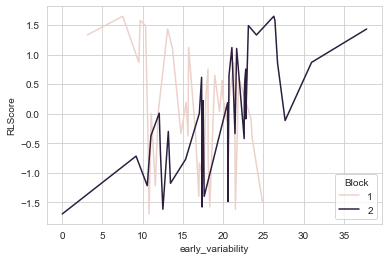

In [148]:
seaborn.lineplot(data=fpca_scores.join(df.to_frame()),
                 y='RLScore', x='early_variability', hue='Block')

In [136]:
from scipy import stats
def r2(data, x, y):   return stats.pearsonr(data[x], data[y])

### for learning block

<AxesSubplot:xlabel='early_variability', ylabel='RLScore'>

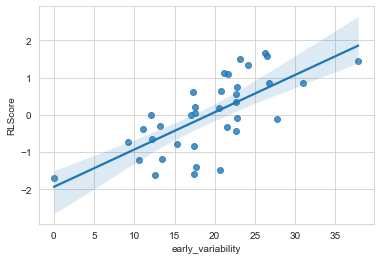

In [149]:
seaborn.regplot(data=fpca_scores.join(df.loc[2].to_frame()),
                 y='RLScore', x='early_variability')

In [150]:
r2(data=fpca_scores.join(df.loc[2].to_frame()),
                 y='RLScore', x='early_variability')

PearsonRResult(statistic=0.6995207689949621, pvalue=2.064310306146691e-06)

### for baseline block

<AxesSubplot:xlabel='early_variability', ylabel='RLScore'>

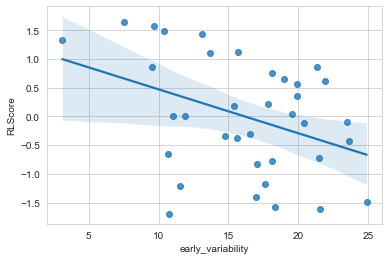

In [151]:
seaborn.regplot(data=fpca_scores.join(df.loc[1].to_frame()),
                 y='RLScore', x='early_variability')

In [152]:
r2(data=fpca_scores.join(df.loc[1].to_frame()),
                 y='RLScore', x='early_variability')

PearsonRResult(statistic=-0.3866202973481253, pvalue=0.019845838943560432)

## correlation with late mean score
not 'fPCA score'

### for learning block

In [141]:
len_window = 30

In [142]:
df_late_score = dfb[(dfb.Block==2) &
                    (dfb.Trial.isin(list(range(200-len_window, 201))))].groupby('Subject').Score.mean()
df_late_score = df_late_score.rename('late_score')

In [143]:
df_late_score.head()

Subject
AB1    49.230769
AG1    69.400000
AH1    46.384615
AM1    70.870968
AN1    30.933333
Name: late_score, dtype: float64

<AxesSubplot:xlabel='early_variability', ylabel='late_score'>

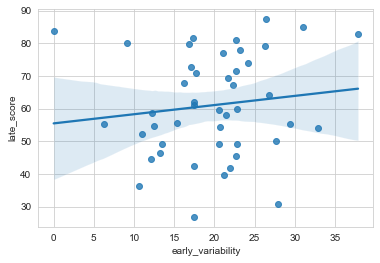

In [144]:
seaborn.regplot(data=df_late_score.to_frame().join(df.loc[2].to_frame()),
                 y='late_score', x='early_variability')

In [145]:
r2(data=df_late_score.to_frame().join(df.loc[2].to_frame()),
                 y='late_score', x='early_variability')

PearsonRResult(statistic=0.12831314070789754, pvalue=0.4009031380310894)

### for baseline block

<AxesSubplot:xlabel='early_variability', ylabel='late_score'>

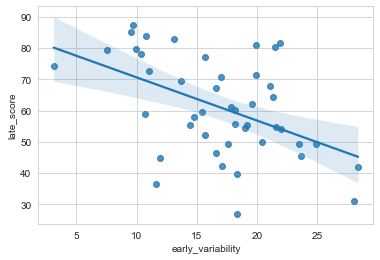

In [146]:
seaborn.regplot(data=df_late_score.to_frame().join(df.loc[1].to_frame()),
                 y='late_score', x='early_variability')

In [147]:
r2(data=df_late_score.to_frame().join(df.loc[1].to_frame()),
                 y='late_score', x='early_variability')

PearsonRResult(statistic=-0.4751981634554003, pvalue=0.0009715457374206884)